In [1]:
import mne
#from mne_bids import (BIDSPath, read_raw_bids, print_dir_tree, make_report,
#                      find_matching_paths, get_entity_vals)
import numpy as np
import matplotlib.pyplot as plt
# import scipy as sp
# from scipy import signal
# import seaborn as sns
import pandas as pd
from pathlib import Path
import os
from time import time
from autoreject import AutoReject, Ransac, get_rejection_threshold

%matplotlib qt

In [2]:
# Initialize an empty dictionary for subject grouping
subject_groups = {}

# Add subjects to the dictionary based on their group
for i in range(1, 25):
    subject_groups[f"sub-{i:03d}"] = "htr" #Himalayan

for i in range(25, 56):
    subject_groups[f"sub-{i:03d}"] = "ctr" #Control

for i in range(56, 60):
    subject_groups[f"sub-{i:03d}"] = "tm" #Transcendental???

for i in range(60, 79):
    subject_groups[f"sub-{i:03d}"] = "vip" #Vipassana

for i in range(79, 99):
    subject_groups[f"sub-{i:03d}"] = "sny" #Shoonya Yoga


# Creating event id for each task and practice
event_id = {'htr/med1':1, 'htr/med2':2, 'htr/think1':3, 'htr/think2':4,
          'ctr/med1':5, 'ctr/med2':6, 'ctr/think1':7, 'ctr/think2':8,
          'tm/med1': 9, 'tm/med2' :10, 'tm/think1':11, 'tm/think2':12,
          'vip/med1':13, 'vip/med2':14, 'vip/think1':15, 'vip/think2':16,
          'sny/med1':17, 'sny/med2':18, 'sny/think1':19, 'sny/think2':20}




def load_task_data(bids_root, subject_id, tasks):
    """
    Load specific task EEG data for a subject from a BIDS-like dataset.
    
    Parameters:
    - bids_root: str, path to the root of the dataset.
    - subject_id: str, subject identifier (e.g., '088').
    - tasks: list of str, the task names to load (e.g., ['med2', 'think2']).
    
    Returns:
    - raw_dict: dict, containing MNE Raw objects for each task.
    """
    # Define the subject's EEG folder
    subject_path = os.path.join(bids_root, f"sub-{subject_id}", "eeg")
    
    if not os.path.exists(subject_path):
        raise FileNotFoundError(f"Subject folder not found: {subject_path}")
    
    raw_dict = {}  # Dictionary to hold Raw objects for each task
    
    for task in tasks:
        # Locate the BDF file for the specific task
        bdf_file = os.path.join(subject_path, f"sub-{subject_id}_task-{task}_eeg.bdf")
        if not os.path.exists(bdf_file):
            print(f"WARNING: BDF file not found for task '{task}'. Skipping...")
            continue
        
        # Load the BDF file
        raw = mne.io.read_raw_bdf(bdf_file, preload=True)
        print(f"Loaded BDF file for task '{task}': {bdf_file}")
        
        # Optionally, load metadata from JSON/TSV files
        # Metadata file paths
        json_file = os.path.join(subject_path, f"sub-{subject_id}_task-{task}_eeg.json")
        tsv_file = os.path.join(subject_path, f"sub-{subject_id}_task-{task}_channels.tsv")
        
        metadata = {}
        if os.path.exists(json_file):
            with open(json_file, 'r') as f:
                metadata['json'] = f.read()
            print(f"Loaded metadata JSON for task '{task}'")
        
        if os.path.exists(tsv_file):
            metadata['tsv'] = tsv_file  # Store TSV file path for later use if needed
            print(f"Loaded metadata TSV for task '{task}'")
        
        # Add the loaded data and metadata to the dictionary
        raw_dict[task] = {
            'raw': raw,
            'metadata': metadata
        }
    
    if not raw_dict:
        raise ValueError(f"No data was loaded for subject {subject_id} with tasks {tasks}.")
    
    return raw_dict


In [3]:
# Print out intiation text with path to the dataset and events
print("\n##### Initiating the preprocessing pipeline for the Braboszcz et al. (2017) dataset. ######")

bids_root = "/home/sivert/Documents/Specialization_project/Datasets/ds003969/"
subject_id = "077"
tasks = ["med2", "think2"]
subject_group = subject_groups['sub-'+subject_id]

print('\n##### Loading data #####')
# Load data
subject_data = load_task_data(bids_root, subject_id, tasks)

# Access raw data for a specific task
raw_med = subject_data['med2']['raw']
raw_med.set_channel_types({'EXG1': 'misc',
                    'EXG2': 'misc',
                    'EXG3': 'misc',
                    'EXG4': 'misc',
                    'EXG5': 'misc',
                    'EXG6': 'misc',
                    'EXG7': 'misc',
                    'EXG8': 'misc',
                    'GSR1': 'misc',
                    'GSR2': 'misc',
                    'Erg1': 'misc',
                    'Erg2': 'misc',
                    'Resp': 'bio',
                    'Plet': 'bio',
                    'Temp': 'bio'
})
# Drop non-eeg channels
#raw_med.pick('eeg')

raw_med.plot(highpass=1, lowpass=None, block=True)


from mne.channels import find_ch_adjacency
from mne.viz import plot_ch_adjacency




##### Initiating the preprocessing pipeline for the Braboszcz et al. (2017) dataset. ######

##### Loading data #####


FileNotFoundError: Subject folder not found: /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-077\eeg

No bad channels found for sub-003 - task-med2
Extracting EDF parameters from /home/sivert/Documents/Master_AttentionalDirectionResearch/data/braboszcz2017/raw/sub-003/eeg/sub-003_task-med2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 617471  =      0.000 ...   602.999 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)


/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/preprocessing_tools.py:65: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  raw.set_channel_types(existing_types)


Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Channels marked as bad:
none


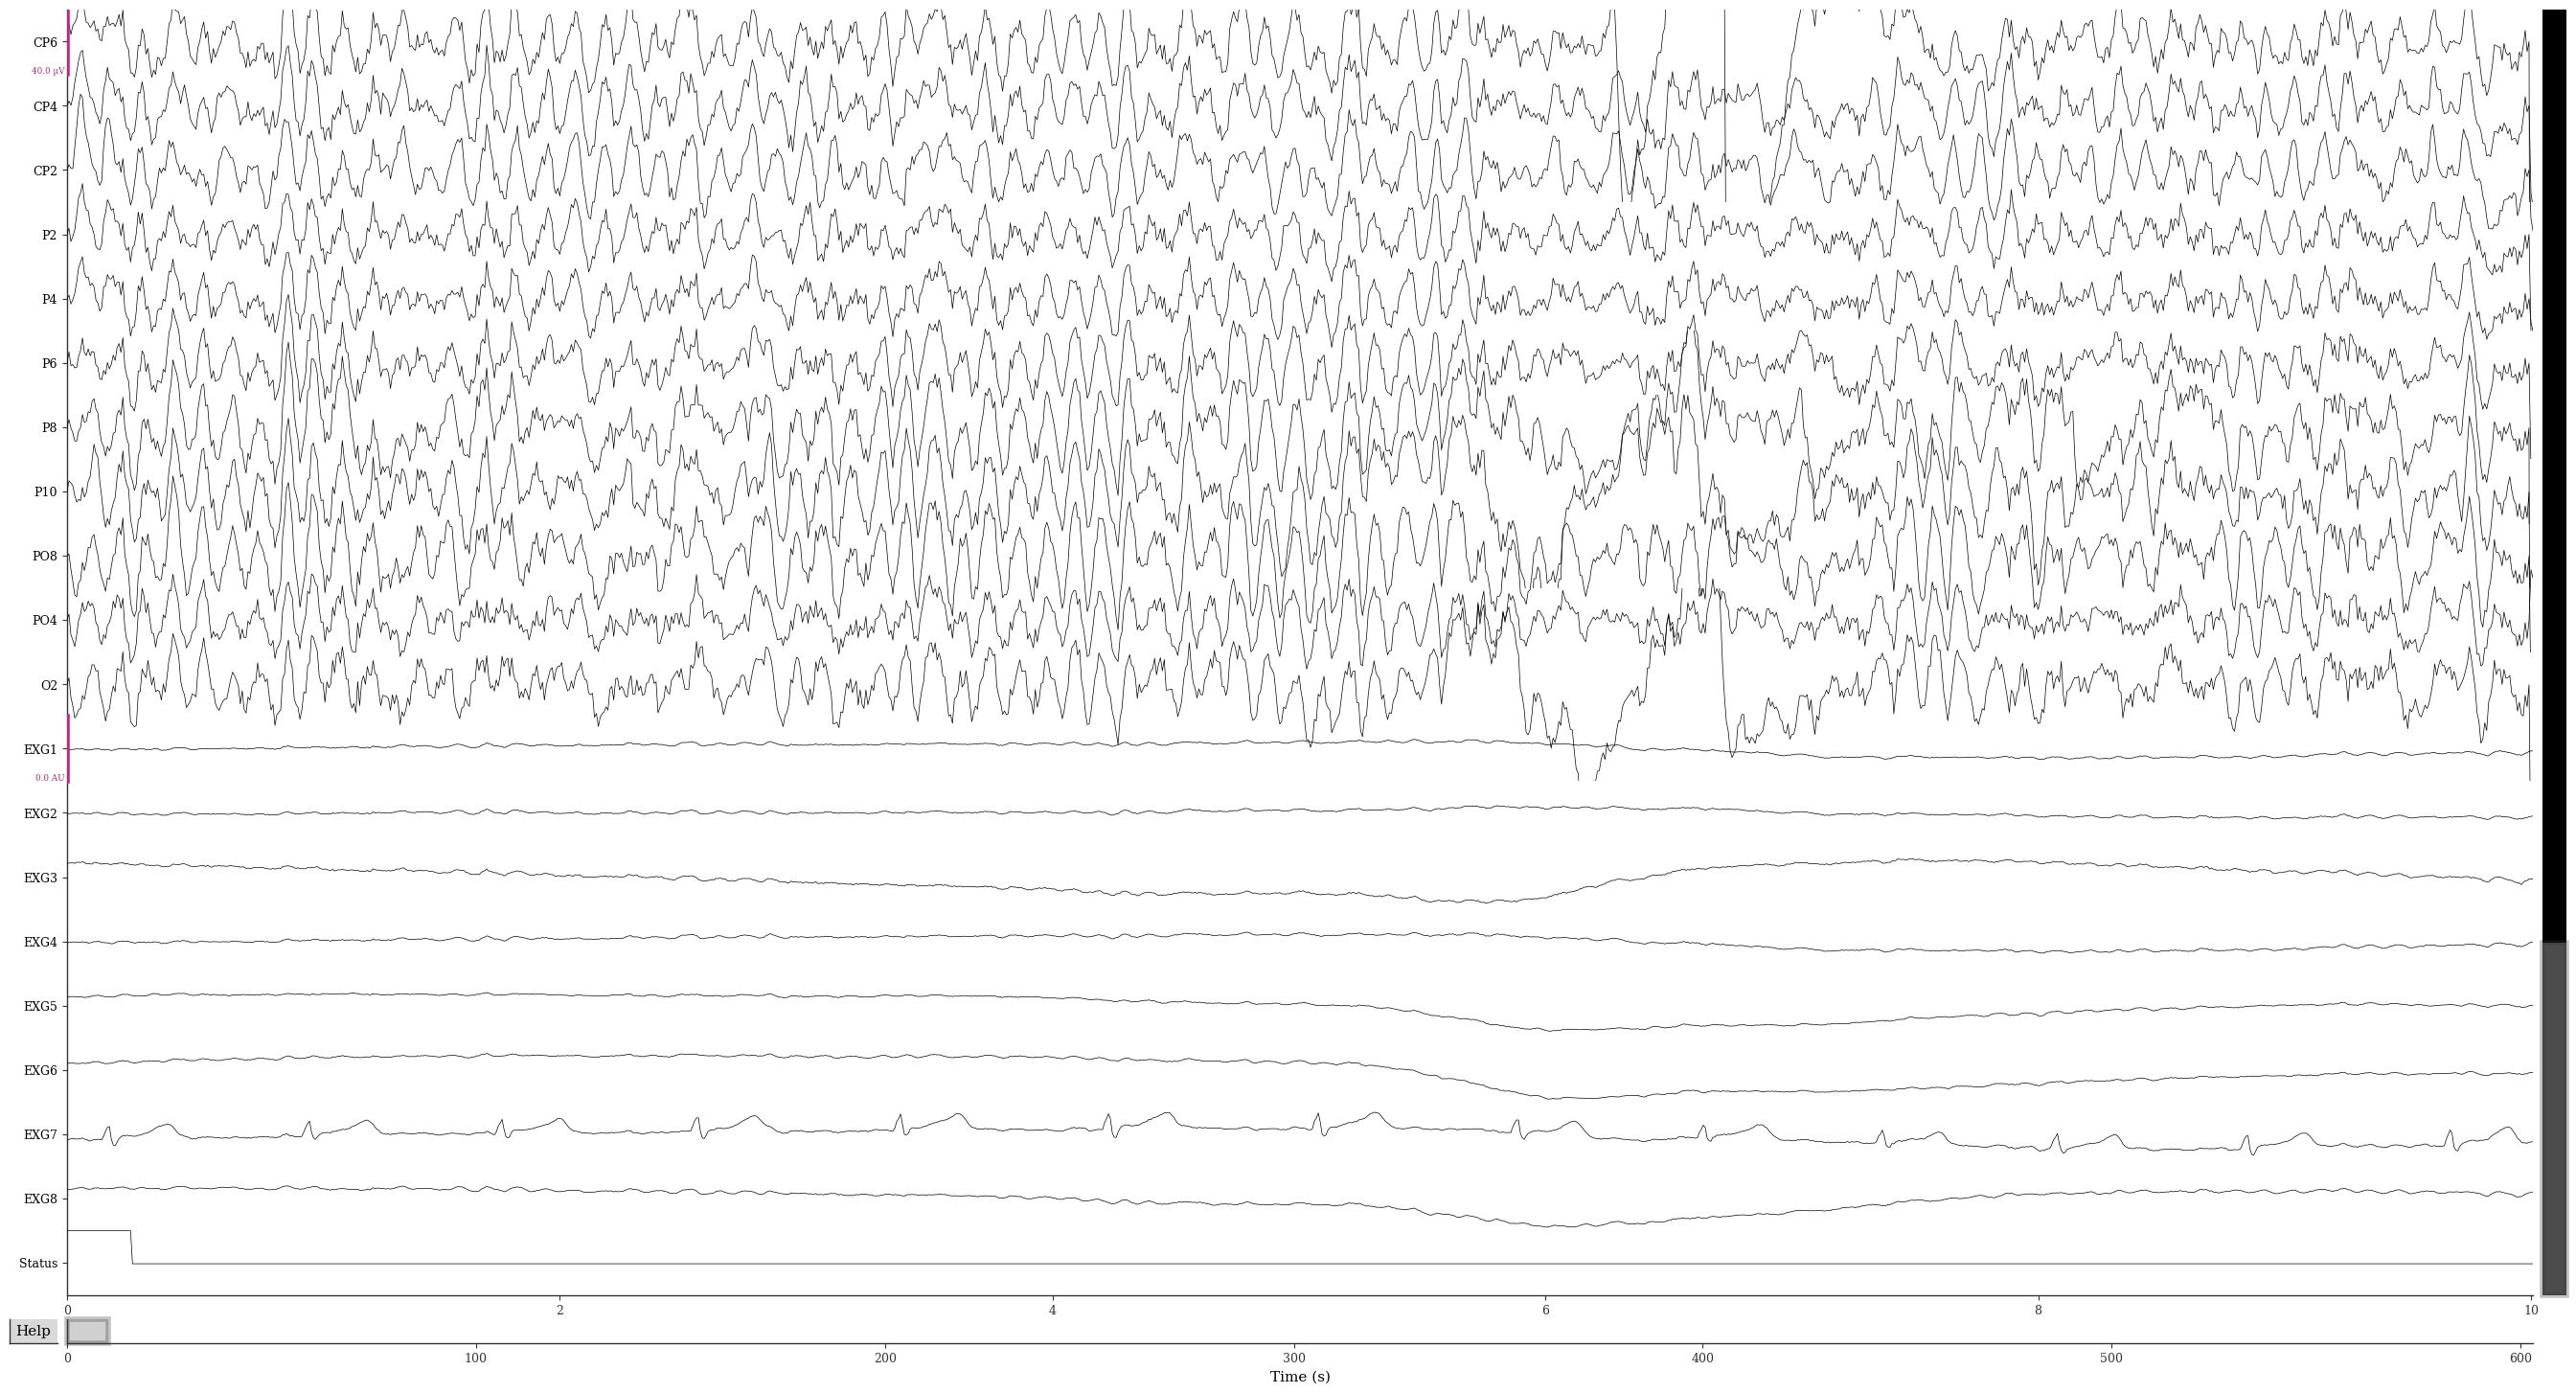

In [3]:
from utils.file_io import load_raw_data, load_bad_channels
from utils.preprocessing_tools import prepare_raw_data
from utils.config import DATASETS, set_plot_style, EEG_SETTINGS
import utils.config as config

%matplotlib qt

set_plot_style()

DATASET = DATASETS['braboszcz2017']
path_derivatives = DATASET.path_derivatives
subject = '003'
task = 'med2'

bad_chs = load_bad_channels(
        save_dir=path_derivatives,
        dataset=DATASET.f_name,
        subject=subject,
        task=task
    )

raw = load_raw_data(dataset=DATASET, subject=subject, task=task)

raw = prepare_raw_data(raw, dataset=DATASET, eeg_settings=config.EEG_SETTINGS)

#raw.info['bads'] = bad_chs

raw.plot(highpass=1, lowpass=None, block=True)


Found existing bad channels for sub-6 - ses-2
Extracting EDF parameters from /home/sivert/Documents/Master_AttentionalDirectionResearch/data/jin2019/raw/sub6_2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2928639  =      0.000 ...  5719.998 secs...


/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/preprocessing_tools.py:96: RuntimeWarning: The unit for channel(s) EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  raw.set_channel_types({


Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
826 events found on stim channel Status
Event IDs: [   10    11    12    13    14    20    21 65790]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
825 events found on stim channel Status
Event IDs: [10 11 12 13 14 20 21]
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB



/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/preprocessing_tools.py:115: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  raw.resample(eeg_settings["SAMPLING_RATE"])


Channels marked as bad:
none


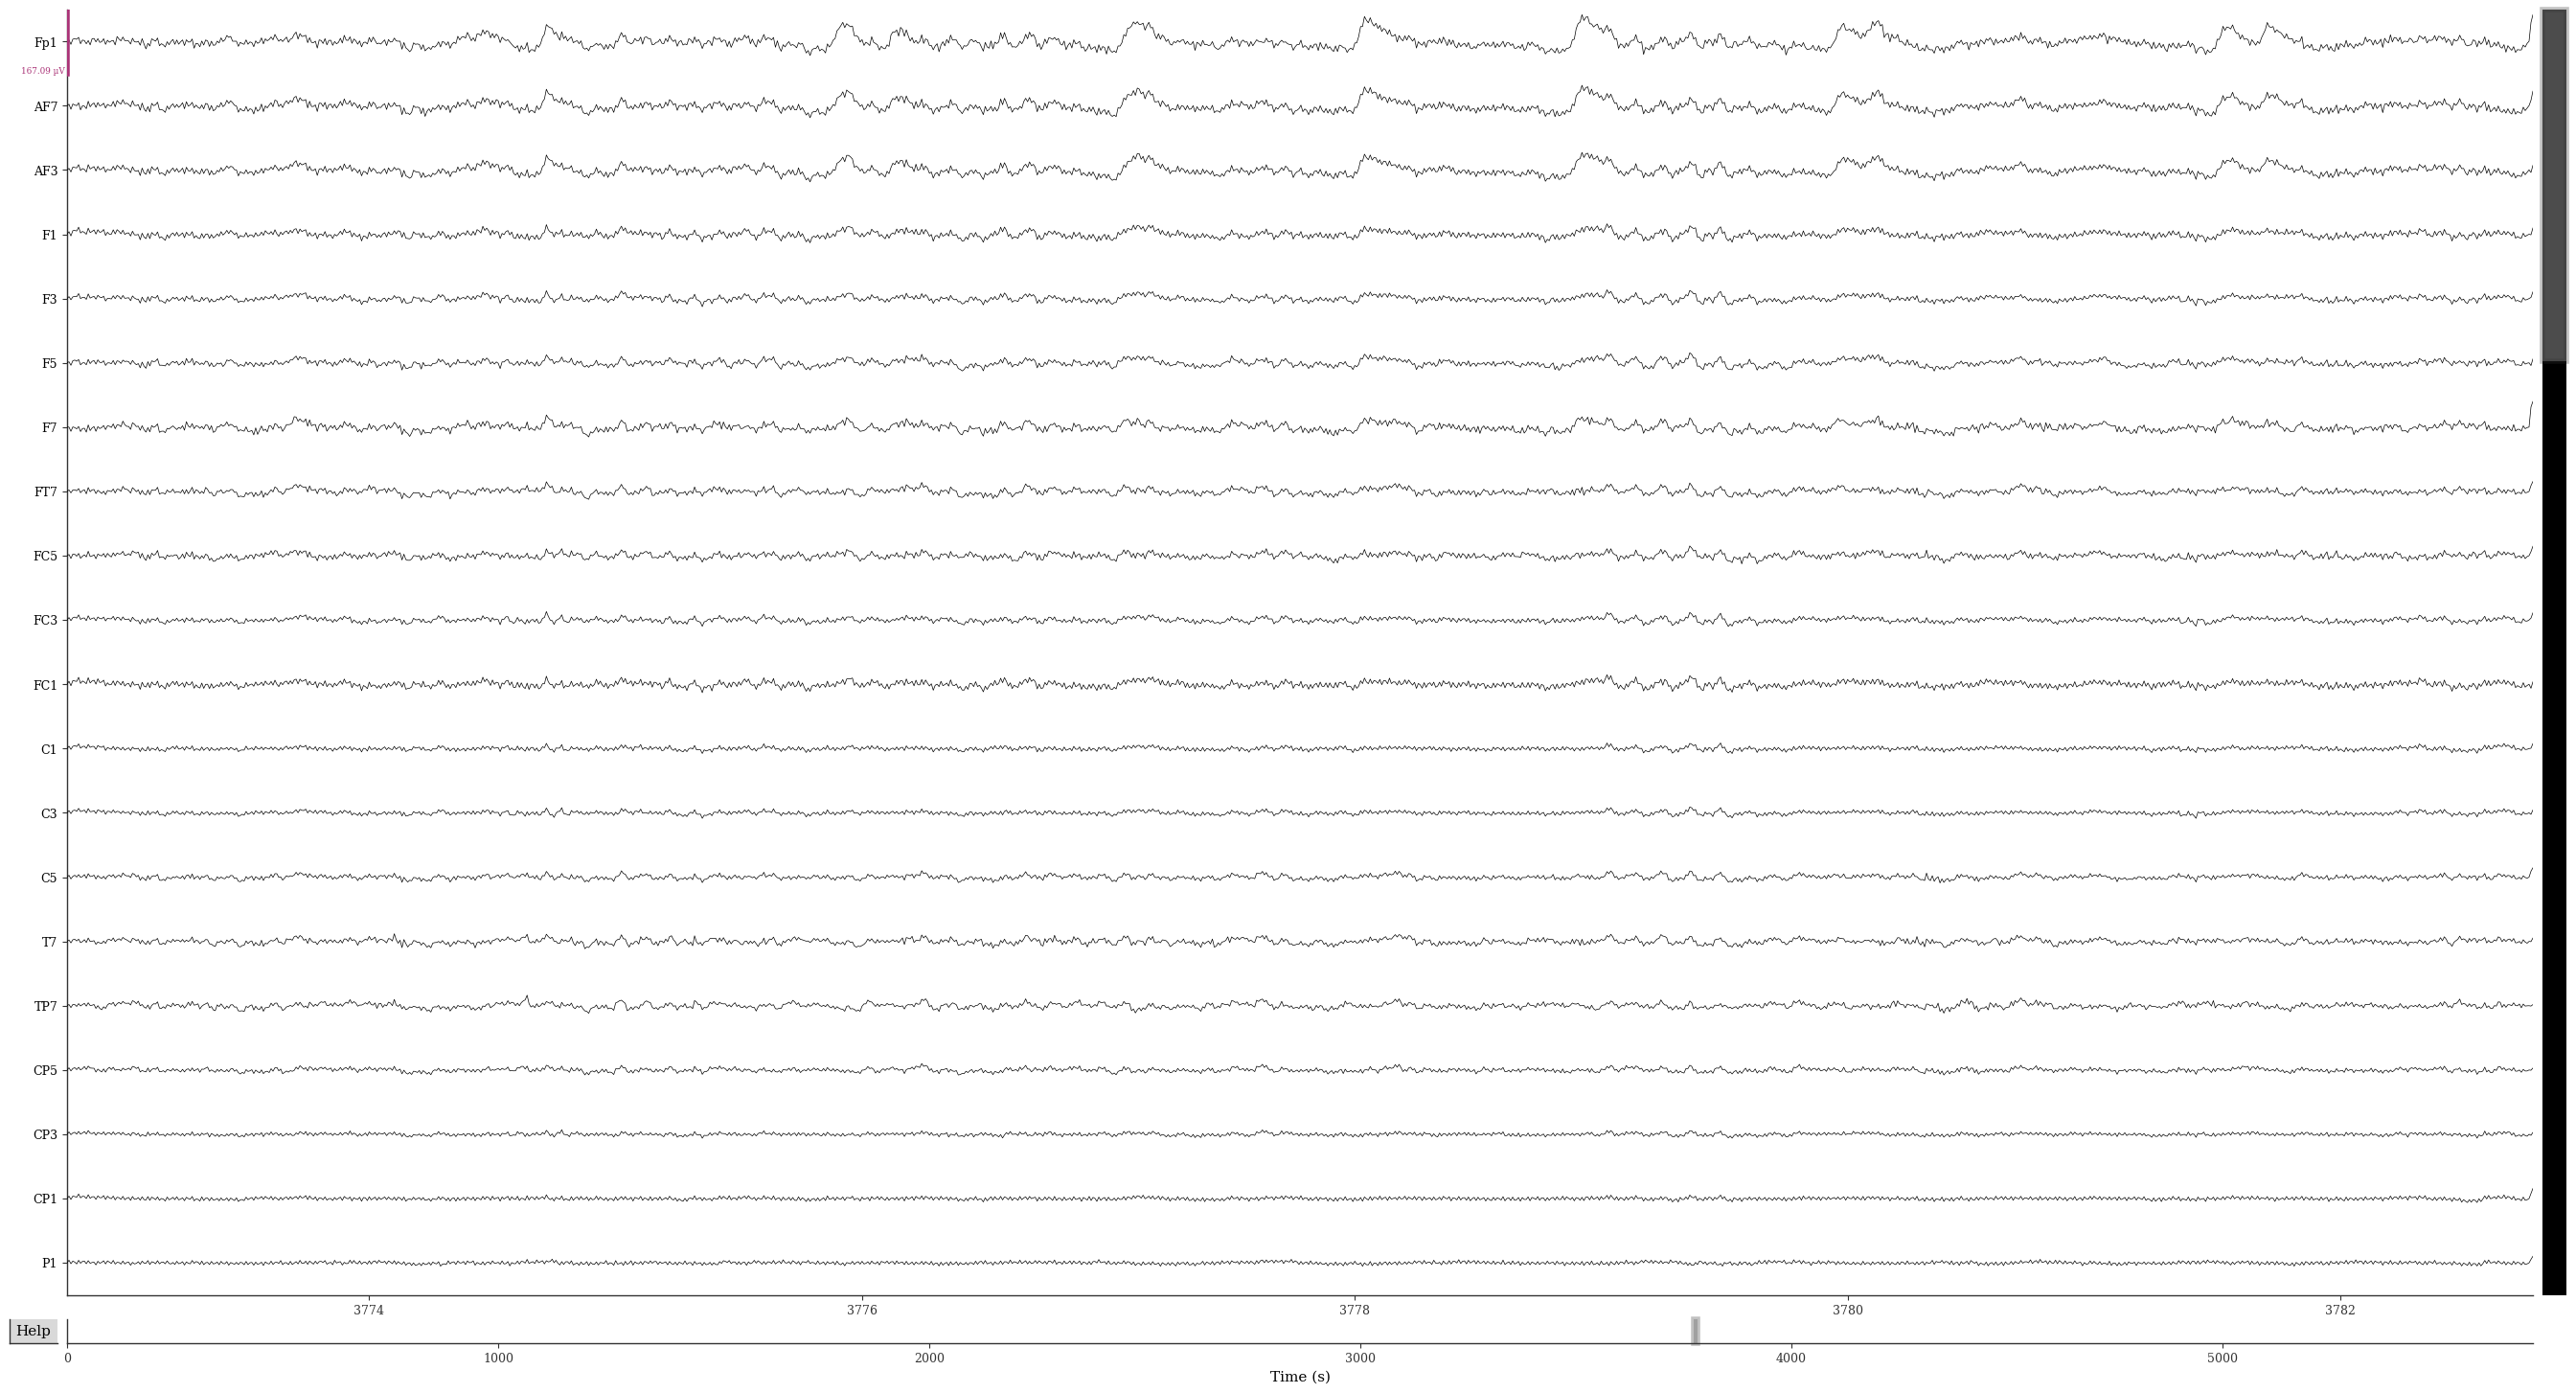

In [ ]:
from utils.file_io import load_raw_data, load_bad_channels
from utils.preprocessing_tools import prepare_raw_data
from utils.config import DATASETS
import utils.config as config

DATASET = DATASETS['jin2019']
path_derivatives = DATASET.path_derivatives
subject = 6
session = 2

bad_chs = load_bad_channels(
        save_dir=path_derivatives,
        dataset=DATASET.f_name,
        subject=subject,
        session=session
    )

raw = load_raw_data(dataset=DATASET, subject=subject, session=session)

raw = prepare_raw_data(raw, dataset=DATASET, eeg_settings=config.EEG_SETTINGS)

raw.info['bads'] = bad_chs

raw.plot(highpass=1, lowpass=None, block=True)



qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""
/home/sivert/anaconda3/envs/mne-env/lib/python3.9/site-packages/pymatreader/utils.py:168: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(
/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/file_io.py:53: RuntimeWarning: Unknown types found, setting as type EEG:
other: ['ANG', 'LN', 'SD', 'SP']
  return mne.io.read_raw_eeglab(path, preload=preload, verbose=verbose)
/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/file_io.py:53: RuntimeWarning: Not setting positions of 6 eog/misc channels found in montage:
['LHEOG', 'RHEOG', 'UVEOG', 'LVEOG', 'LMAST', 'RMAST']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  return mne.io.read_raw_eeglab(path, preload=preload, verbose=v

Used Annotations descriptions: ['1111', '1112', '1121', '1122', '1211', '1212', '1341', '1342', '2221', '2222', '2241', '2242', '2251', '2252', '2621', '2622', '2631', '2632', '2811', '2812', '3111', '3112', '3200', '3310', '4210', '4220', '4230', '4311', '4312', '4411', '4421', '4621', '4622', '4730']
[INFO] No events found for 'police_detection/MW' (code 9999). Skipping.
[INFO] Creating epochs for 'collision/MW' (code 4421)...
[INFO] Created epochs for 'collision/MW' with 3 epochs.
[INFO] Creating epochs for 'police_detection/OT' (code 4621)...
[INFO] Created epochs for 'police_detection/OT' with 20 epochs.
[INFO] Creating epochs for 'collision/OT' (code 8888)...
[INFO] Created epochs for 'collision/OT' with 3 epochs.
Found 0 bad epochs.
Found 0 bad epochs.
Found 0 bad epochs.
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-back

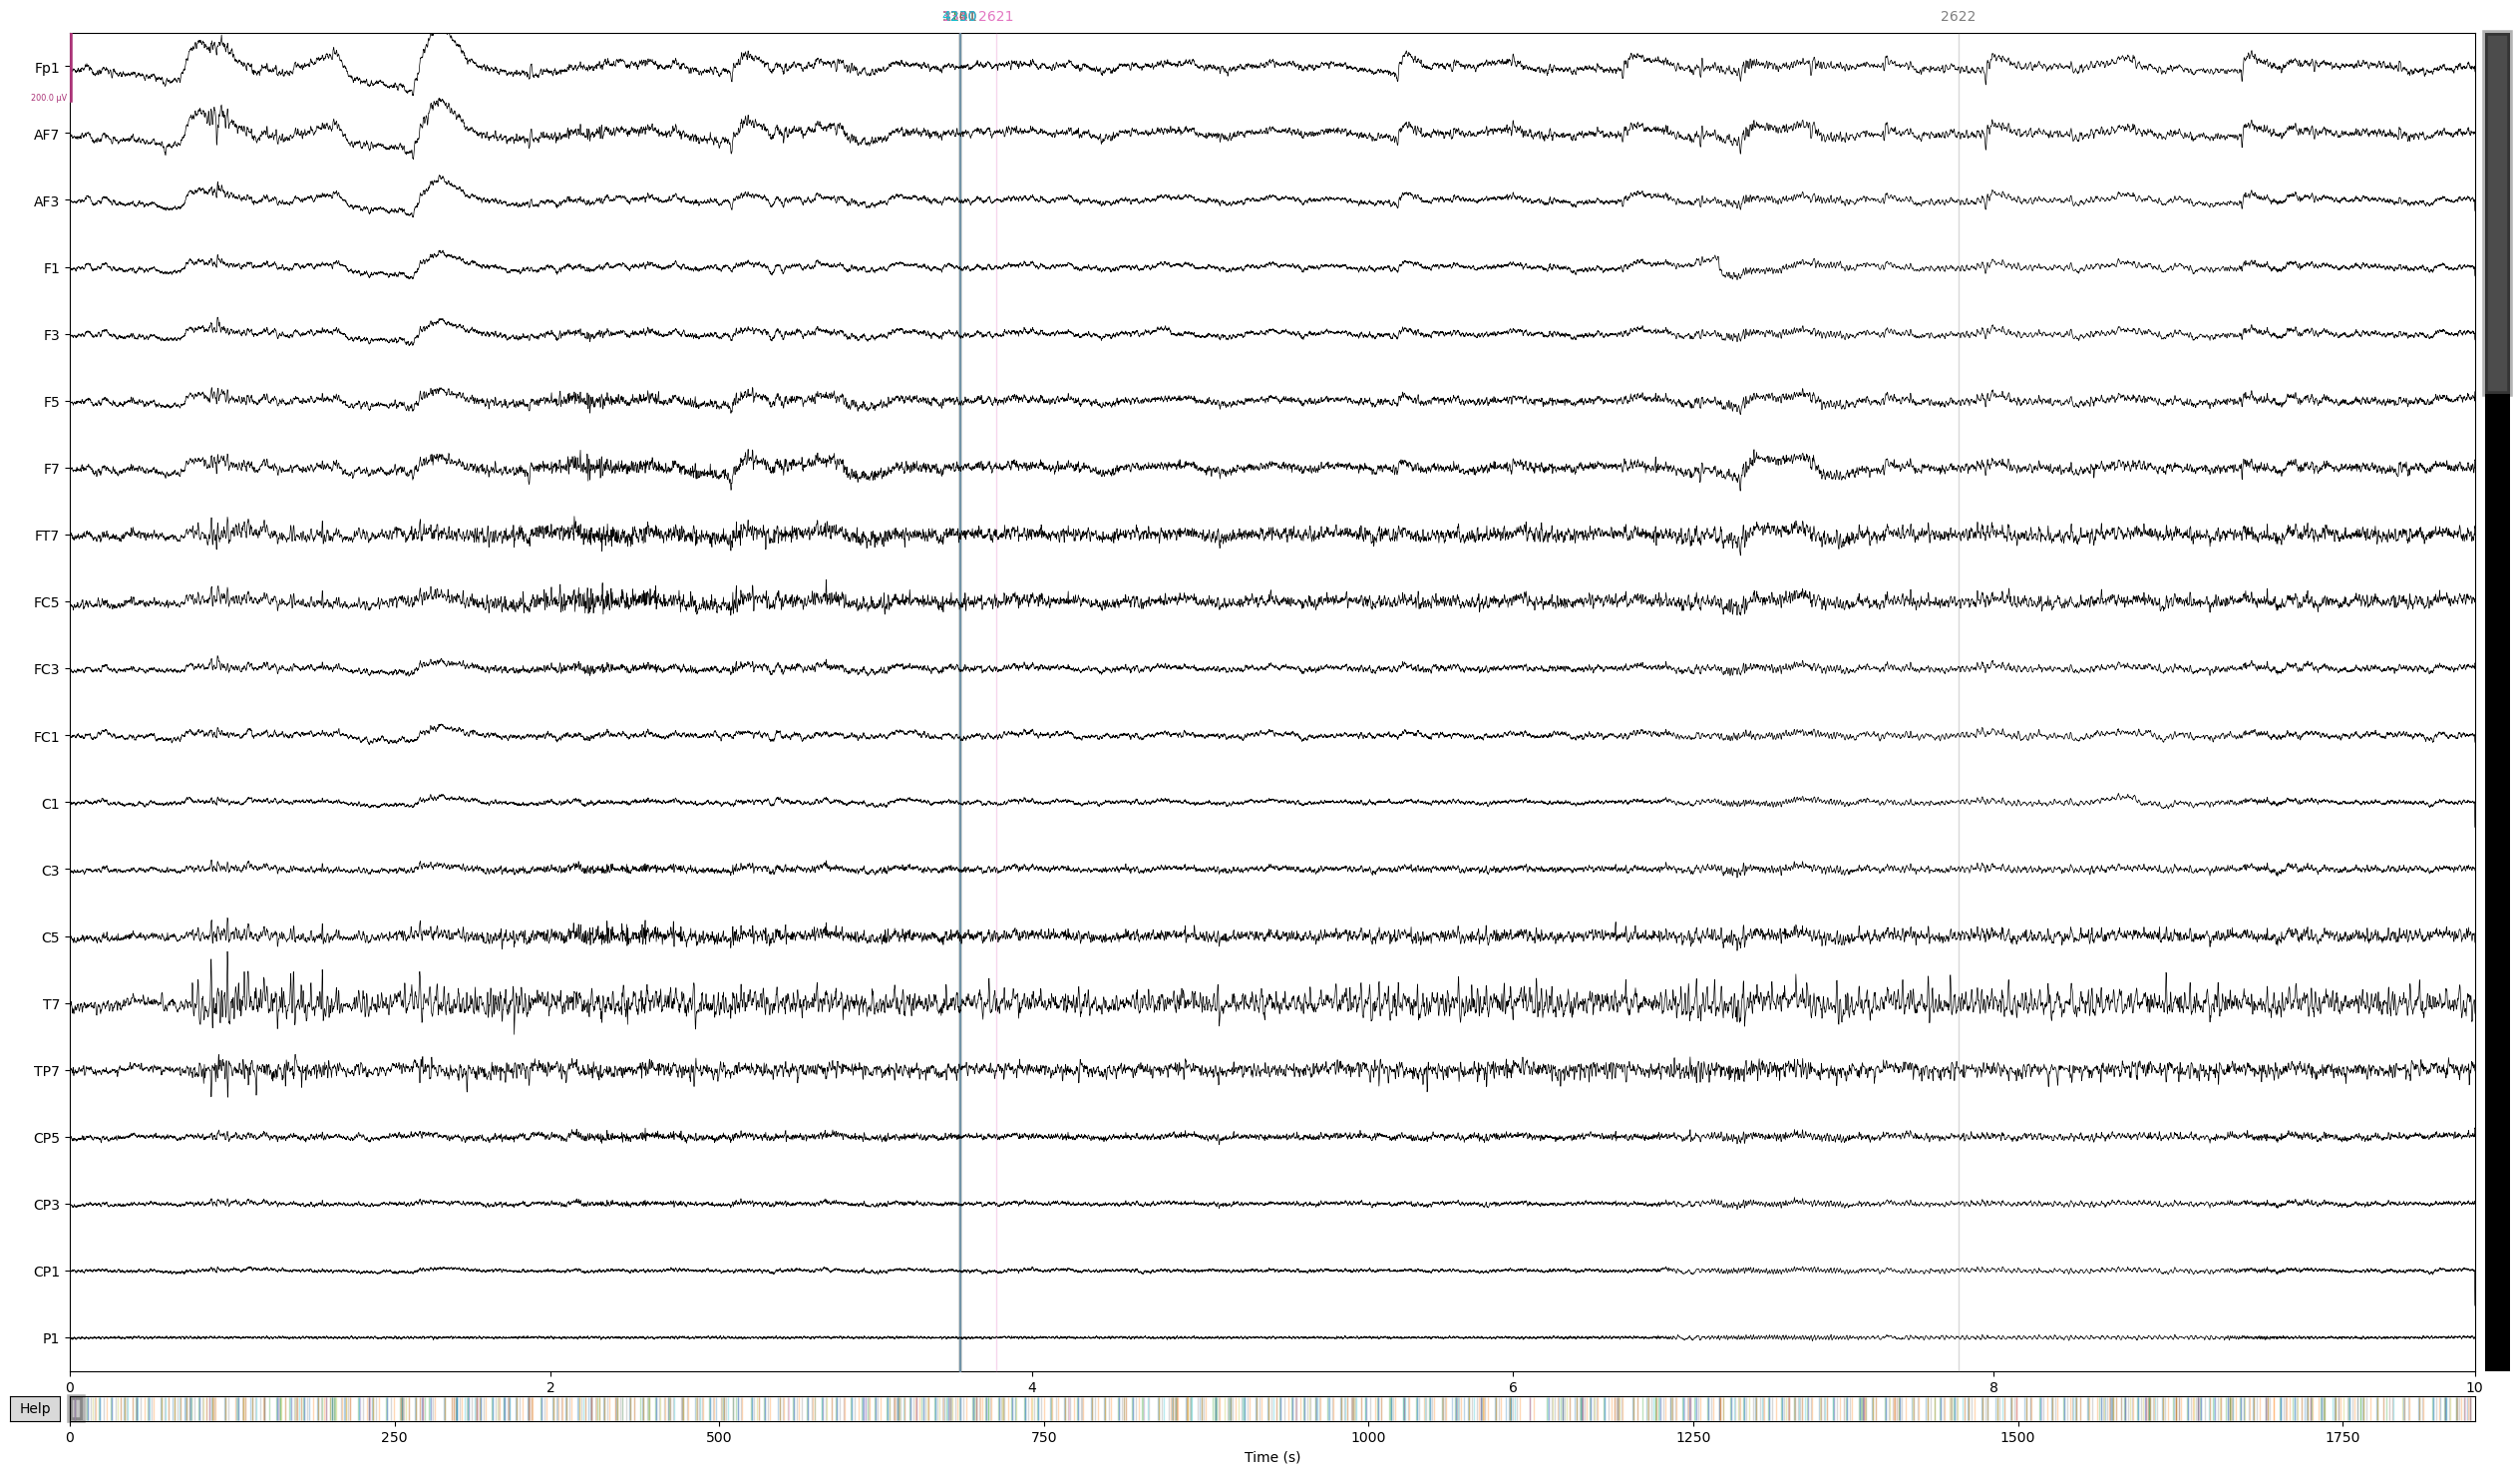

In [1]:
from utils.file_io import load_raw_data, load_bad_channels
from utils.preprocessing_tools import prepare_raw_data, prepare_ica_epochs, create_analysis_epochs
from utils.config import DATASETS
import utils.config as config
import numpy as np

%matplotlib qt

DATASET = DATASETS['touryan2022']
path_derivatives = DATASET.path_derivatives
subject = 1
run = 2

# bad_chs = load_bad_channels(
#         save_dir=path_derivatives,
#         dataset=DATASET.f_name,
#         subject=subject,
#         run=run
#     )

raw = load_raw_data(dataset=DATASET, subject=subject, run=run)

epochs_dict = create_analysis_epochs(
    raw.copy(),
    dataset=DATASET,
    eeg_settings=config.EEG_SETTINGS,
    subject=subject,
    item=run
)
#epochs.plot(block=True, scalings=dict(eeg=150e-6))

for epochs in epochs_dict.values():
    # Plot epochs
    # epochs.plot(block=True, scalings=dict(eeg=150e-6),
    #             title=f'Run {run} - {subject} - {epochs.event_id}')

    # Plot dropped epochs
    bad_epochs = epochs.drop_log

    # Get list of dropped epoch indices from original epochs
    dropped_epoch_indices = [i for i, entry in enumerate(bad_epochs) if len(entry) > 0]

    print(f"Found {len(dropped_epoch_indices)} bad epochs.")

    #plot droplog
    # epochs.plot_drop_log()


raw.plot(highpass=1, scalings=dict(eeg=100e-6), lowpass=None, block=True)

In [6]:
import os
import mne
from autoreject import read_auto_reject, validation_curve, get_rejection_threshold, set_matplotlib_defaults
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from joblib import cpu_count

from utils.preprocessing_tools import prepare_raw_data, fix_bad_channels, get_bad_epochs_mask
from utils.file_io import load_raw_data, load_ar
from utils.config import DATASETS, set_plot_style, EEG_SETTINGS, PLOTS_PATH
from utils.helpers import cleanup_memory, iterate_dataset_items

set_plot_style()

VERBOSE = False
SHOW_PLOTS = False

DATASETS.pop('braboszcz2017')
DATASETS.pop('jin2019')


for dataset, subject, label, item, kwargs in iterate_dataset_items(DATASETS):
    ar = load_ar(dataset, subject, label, item, verbose=VERBOSE)
    if ar is None:
        continue

    rej_thr = np.mean(list(ar.threshes_.values()))*1e6
    print(f"Rejection threshold: {rej_thr:.6f} µV")

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

[DATASET PROGRESSION] Processing dataset: Touryan et al. (2022)


                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                       

[SUBJECT PROGRESSION] Processing subject: 01



                                               
                                                                   

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                       

[ ITEM  PROGRESSION ] Processing run: 2
Rejection threshold: 47.900621 µV
[SUBJECT PROGRESSION] Processing subject: 02



                                               
                                                                   

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                               

[ ITEM  PROGRESSION ] Processing run: 2
Rejection threshold: 26.044166 µV
[SUBJECT PROGRESSION] Processing subject: 03



                                               
                                                                           

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                               

[ ITEM  PROGRESSION ] Processing run: 2
[SUBJECT PROGRESSION] Processing subject: 04



                                               
                                                                           

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

[ ITEM  PROGRESSION ] Processing run: 2




                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                               

[SUBJECT PROGRESSION] Processing subject: 05



                                               
                                                                           

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                               

[ ITEM  PROGRESSION ] Processing run: 2
[SUBJECT PROGRESSION] Processing subject: 06



                                               
                                                                           

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                               

[ ITEM  PROGRESSION ] Processing run: 2
[SUBJECT PROGRESSION] Processing subject: 07



                                               
                                                                           

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                               

[ ITEM  PROGRESSION ] Processing run: 2
[SUBJECT PROGRESSION] Processing subject: 08



                                               
                                                                           

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]



[ ITEM  PROGRESSION ] Processing run: 2


08 run:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                               

[SUBJECT PROGRESSION] Processing subject: 09



                                               
                                                                           

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                               

[ ITEM  PROGRESSION ] Processing run: 2
[SUBJECT PROGRESSION] Processing subject: 10



                                               
                                                                           

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                               

[ ITEM  PROGRESSION ] Processing run: 2
[SUBJECT PROGRESSION] Processing subject: 11



                                               
                                                                           

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                               

[ ITEM  PROGRESSION ] Processing run: 2
[SUBJECT PROGRESSION] Processing subject: 12



                                               
                                                                           

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                               

[ ITEM  PROGRESSION ] Processing run: 2
[SUBJECT PROGRESSION] Processing subject: 13



                                               
                                                                           

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                               

[ ITEM  PROGRESSION ] Processing run: 2
[SUBJECT PROGRESSION] Processing subject: 14



                                               
                                                                           

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

14 run:   0%|          | 0/1 [00:00<?, ?it/s]

[ ITEM  PROGRESSION ] Processing run: 2



                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                                

[SUBJECT PROGRESSION] Processing subject: 15



                                               
                                                                            

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]


[ ITEM  PROGRESSION ] Processing run: 2


Touryan et al. (2022) Subjects:  67%|██████▋   | 14/21 [00:00<00:00, 42.62it/s]

                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                                

[SUBJECT PROGRESSION] Processing subject: 16



                                               
                                                                            

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                                

[ ITEM  PROGRESSION ] Processing run: 2
[SUBJECT PROGRESSION] Processing subject: 17



                                               
                                                                            

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]



[ ITEM  PROGRESSION ] Processing run: 2


                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                                

[SUBJECT PROGRESSION] Processing subject: 18



                                               
                                                                            

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                                

[ ITEM  PROGRESSION ] Processing run: 2
[SUBJECT PROGRESSION] Processing subject: 19



                                               
                                                                            

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                                

[ ITEM  PROGRESSION ] Processing run: 2
[SUBJECT PROGRESSION] Processing subject: 20



                                               
                                                                            

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                                

[ ITEM  PROGRESSION ] Processing run: 2
[SUBJECT PROGRESSION] Processing subject: 21



                                               
                                                                            

Datasets:   0%|          | 0/1 [00:00<?, ?it/s]


                                             

[ ITEM  PROGRESSION ] Processing run: 2


Datasets: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


In [1]:
import os
import mne
from autoreject import read_auto_reject, validation_curve, get_rejection_threshold, set_matplotlib_defaults
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from joblib import cpu_count

from utils.preprocessing_tools import prepare_ica_epochs, prepare_raw_data, fix_bad_channels, get_bad_epochs_mask
from utils.file_io import load_raw_data, load_ar
from utils.config import DATASETS, set_plot_style, EEG_SETTINGS, PLOTS_PATH
from utils.helpers import cleanup_memory, iterate_dataset_items

%matplotlib qt

set_plot_style()

VERBOSE = True
SHOW_PLOTS = False

# Remove datasets that are not relevant for this analysis
DATASETS.pop('braboszcz2017')
DATASETS.pop('jin2019')



for dataset, subject, label, item, kwargs in iterate_dataset_items(DATASETS):
    raw = load_raw_data(dataset, subject, **kwargs, verbose=VERBOSE)
    if raw is None:
        continue
    # Prepare raw data
    raw = prepare_raw_data(raw, dataset, EEG_SETTINGS)

    # Fix bad channels
    raw = fix_bad_channels(raw, dataset, subject=subject, **kwargs, verbose=VERBOSE)

    # Filter the raw data
    raw.filter(l_freq=EEG_SETTINGS['LOW_CUTOFF_HZ'], h_freq=None, n_jobs=cpu_count(), verbose=VERBOSE)

    # Create synthetic epochs
    epochs = mne.make_fixed_length_epochs(
        raw,
        duration=EEG_SETTINGS["SYNTHETIC_LENGTH"],
        preload=True,
        verbose=VERBOSE
    )
    epochs.pick(picks=['eeg', 'eog'], verbose=VERBOSE)

    # Average reference
    epochs.set_eeg_reference(ref_channels='average', ch_type='eeg', projection=False, verbose=VERBOSE)

    reject = get_rejection_threshold(
        epochs,
        random_state=42069,
        ch_types='eeg',
        verbose=VERBOSE
    )
    
    reject = {key: val * 2 for key, val in reject.items()}  # Increase the threshold by 100%
    if VERBOSE:
        print(f"[REJECT THRESHOLD] {reject}")

    full_epochs = epochs.copy()
    epochs.drop_bad(reject, verbose=VERBOSE)


    # Plot dropped epochs
    bad_epochs = epochs.drop_log

    # Get list of dropped epoch indices from original epochs
    dropped_epoch_indices = [i for i, entry in enumerate(bad_epochs) if len(entry) > 0]

    print(f"Found {len(dropped_epoch_indices)} bad epochs.")

    if len(dropped_epoch_indices) > 0:
        # Extract only the previously dropped epochs
        dropped_epochs = full_epochs[dropped_epoch_indices]

        # Plot dropped epochs in red
        dropped_epochs.plot(block=True, scalings=dict(eeg=150e-6),
                            title='Dropped Epochs (bad)')
    else:
        print("No epochs were dropped.")
    
    

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

[DATASET PROGRESSION] Processing dataset: Touryan et al. (2022)


                                               
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                       

[SUBJECT PROGRESSION] Processing subject: 01



                                               

                                       
Datasets:   0%|          | 0/1 [00:00<?, ?it/s]                       
/home/sivert/anaconda3/envs/mne-env/lib/python3.9/site-packages/pymatreader/utils.py:168: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


[ ITEM  PROGRESSION ] Processing run: 2


/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/file_io.py:50: RuntimeWarning: Unknown types found, setting as type EEG:
other: ['ANG', 'LN', 'SD', 'SP']
  return mne.io.read_raw_eeglab(path, preload=preload, verbose=verbose)
/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/file_io.py:50: RuntimeWarning: Not setting positions of 6 eog/misc channels found in montage:
['LHEOG', 'RHEOG', 'UVEOG', 'LVEOG', 'LMAST', 'RMAST']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  return mne.io.read_raw_eeglab(path, preload=preload, verbose=verbose)
/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/preprocessing_tools.py:126: RuntimeWarning: The unit for channel(s) ANG, LN, SD, SP has changed from V to NA.
  raw.set_channel_types({


Found existing bad channels for sub-01 - run-2
No bad channels found for subject 01 with session=None, task=None, run=2. Skipping interpolation.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 845 samples (6.602 s)



[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   6 tasks      | elapsed:    0.9s


Not setting metadata
926 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 926 events and 256 original time points ...
0 bad epochs dropped
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=12)]: Done  64 out of  64 | elapsed:    1.1s finished


Estimating rejection dictionary for eeg
[REJECT THRESHOLD] {'eeg': 0.00029236185317106525}
    Rejecting  epoch based on EEG : ['FT8', 'FC6']
    Rejecting  epoch based on EEG : ['FT7', 'FC5', 'C5', 'T7']
    Rejecting  epoch based on EEG : ['FC5', 'T7', 'FT8', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FT8', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F8']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FT8', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['AF8', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'C6', 'T8']
    Rejecting  epoch based on EEG : ['F6', 'F8', 'FT8', 'FC6']
    Rejecting  epoch based on EEG : ['FT8', 'FC6']
    Rejecting  epoch based on EEG : ['F6', 'F8', 'FT8', 'FC6']
15 bad epoc



                                               
Datasets:   0%|          | 0/1 [01:01<?, ?it/s]                               

[SUBJECT PROGRESSION] Processing subject: 02



                                               
                                                                           

Datasets:   0%|          | 0/1 [01:01<?, ?it/s]


[ ITEM  PROGRESSION ] Processing run: 2


/home/sivert/anaconda3/envs/mne-env/lib/python3.9/site-packages/pymatreader/utils.py:168: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(
/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/file_io.py:50: RuntimeWarning: Unknown types found, setting as type EEG:
other: ['ANG', 'LN', 'SD', 'SP']
  return mne.io.read_raw_eeglab(path, preload=preload, verbose=verbose)
/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/file_io.py:50: RuntimeWarning: Not setting positions of 6 eog/misc channels found in montage:
['LHEOG', 'RHEOG', 'UVEOG', 'LVEOG', 'LMAST', 'RMAST']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  return mne.io.read_raw_eeglab(path, preload=preload, verbose=verbose)
/home/sivert/Documents/Master_AttentionalDirectionResearch/ut

Found existing bad channels for sub-02 - run-2
No bad channels found for subject 02 with session=None, task=None, run=2. Skipping interpolation.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 845 samples (6.602 s)



[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   6 tasks      | elapsed:    0.1s


Not setting metadata
948 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 948 events and 256 original time points ...
0 bad epochs dropped
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=12)]: Done  64 out of  64 | elapsed:    0.3s finished


Estimating rejection dictionary for eeg
[REJECT THRESHOLD] {'eeg': 0.00010579075463258862}
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FT7', 'FC5', 'T7', 'F6', 'F8', 'FC6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'T7', 'Fp2', 'AF8', 'F6', 'F8', 'FT8', 'FC6', 'C6']
    Rejecting  epoch based on EEG : ['FC5', 'FC6']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FT7', 'FC5', 'T7', 'Fp2', 'F6', 'F8', 'FT8', 'FC6']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FT7', 'FC5', 'F6', 'F8', 'FC6']
    Rejecting  epoch based on EEG : ['F5', 'FC5', 'F6', 'F8', 'FC6']
    Rejecting  epoch based on EEG : ['F5', 'FC5', 'C5', 'FC6']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejectin



                                               
Datasets:   0%|          | 0/1 [02:24<?, ?it/s]                               

[SUBJECT PROGRESSION] Processing subject: 03



                                               

                                       
Datasets:   0%|          | 0/1 [02:24<?, ?it/s]                               


[ ITEM  PROGRESSION ] Processing run: 2


/home/sivert/anaconda3/envs/mne-env/lib/python3.9/site-packages/pymatreader/utils.py:168: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(
/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/file_io.py:50: RuntimeWarning: Unknown types found, setting as type EEG:
other: ['ANG', 'LN', 'SD', 'SP']
  return mne.io.read_raw_eeglab(path, preload=preload, verbose=verbose)
/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/file_io.py:50: RuntimeWarning: Not setting positions of 6 eog/misc channels found in montage:
['LHEOG', 'RHEOG', 'UVEOG', 'LVEOG', 'LMAST', 'RMAST']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  return mne.io.read_raw_eeglab(path, preload=preload, verbose=verbose)
/home/sivert/Documents/Master_AttentionalDirectionResearch/ut

Found existing bad channels for sub-03 - run-2
No bad channels found for subject 03 with session=None, task=None, run=2. Skipping interpolation.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 845 samples (6.602 s)



[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   6 tasks      | elapsed:    0.0s


Not setting metadata
921 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 921 events and 256 original time points ...
0 bad epochs dropped
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=12)]: Done  64 out of  64 | elapsed:    0.2s finished


Estimating rejection dictionary for eeg
[REJECT THRESHOLD] {'eeg': 0.00032693309193229723}
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : ['P9', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FT7', 'FC5', 'C5', 'T7', 'P9', 'FT8', 'FC6']
    Rejecting  epoch based on EEG : ['F5', 'FC5', 'T7']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FT7', 'FC5', 'C5', 'T7', 'FT8', 'FC6']
    Rejecting  epoch based on EEG : ['FC5', 'FC6']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'T7', 'FT8']
    Rejecting  epoch based on EEG : ['P9', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'C3', 'C5', 'T7', 'TP7', 'P9', 'AF8', 'F6', 'F8', 'FT8', 'FC6']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FC5', 'C5', 'T7']
    Rejecting  epoch based on EEG : ['FC5', 'FC6']
    Rejecting  epoch based on EEG : ['FC5', 'T7', 'AF8', 'FT8', 'FC6', 'C6', 'T8']
    Rejecting  epoch based on EEG : ['AF7', 'F5'



                                               
Datasets:   0%|          | 0/1 [03:14<?, ?it/s]                               

[SUBJECT PROGRESSION] Processing subject: 04



                                               
                                                                           

Datasets:   0%|          | 0/1 [03:14<?, ?it/s]


[ ITEM  PROGRESSION ] Processing run: 2


/home/sivert/anaconda3/envs/mne-env/lib/python3.9/site-packages/pymatreader/utils.py:168: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(
/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/file_io.py:50: RuntimeWarning: Unknown types found, setting as type EEG:
other: ['ANG', 'LN', 'SD', 'SP']
  return mne.io.read_raw_eeglab(path, preload=preload, verbose=verbose)
/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/file_io.py:50: RuntimeWarning: Not setting positions of 6 eog/misc channels found in montage:
['LHEOG', 'RHEOG', 'UVEOG', 'LVEOG', 'LMAST', 'RMAST']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  return mne.io.read_raw_eeglab(path, preload=preload, verbose=verbose)
/home/sivert/Documents/Master_AttentionalDirectionResearch/ut

Found existing bad channels for sub-04 - run-2
No bad channels found for subject 04 with session=None, task=None, run=2. Skipping interpolation.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 845 samples (6.602 s)



[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   6 tasks      | elapsed:    0.0s


Not setting metadata
917 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 917 events and 256 original time points ...
0 bad epochs dropped
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=12)]: Done  64 out of  64 | elapsed:    0.2s finished


Estimating rejection dictionary for eeg
[REJECT THRESHOLD] {'eeg': 0.0003661537004355994}
    Rejecting  epoch based on EEG : ['TP7', 'P5', 'P7', 'PO3']
    Rejecting  epoch based on EEG : ['P3', 'P5', 'P7', 'PO7', 'PO3']
    Rejecting  epoch based on EEG : ['P5', 'P7']
    Rejecting  epoch based on EEG : ['TP7', 'CP5', 'CP3', 'P3', 'P5', 'P7']
    Rejecting  epoch based on EEG : ['CP5', 'P5']
    Rejecting  epoch based on EEG : ['TP7', 'CP5', 'CP3', 'P3', 'P5', 'P7']
    Rejecting  epoch based on EEG : ['C5', 'T7', 'TP7', 'CP5', 'CP3', 'P3', 'P5', 'P7', 'PO3']
    Rejecting  epoch based on EEG : ['TP7', 'CP5', 'P3', 'P5', 'P7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9']
11 bad epochs dropped
Found 11 bad epochs.
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none




                                               
Datasets:   0%|          | 0/1 [04:45<?, ?it/s]                               

[SUBJECT PROGRESSION] Processing subject: 05



                                               
                                                                           

Datasets:   0%|          | 0/1 [04:45<?, ?it/s]


[ ITEM  PROGRESSION ] Processing run: 2


/home/sivert/anaconda3/envs/mne-env/lib/python3.9/site-packages/pymatreader/utils.py:168: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(
/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/file_io.py:50: RuntimeWarning: Unknown types found, setting as type EEG:
other: ['ANG', 'LN', 'SD', 'SP']
  return mne.io.read_raw_eeglab(path, preload=preload, verbose=verbose)
/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/file_io.py:50: RuntimeWarning: Not setting positions of 6 eog/misc channels found in montage:
['LHEOG', 'RHEOG', 'UVEOG', 'LVEOG', 'LMAST', 'RMAST']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  return mne.io.read_raw_eeglab(path, preload=preload, verbose=verbose)
/home/sivert/Documents/Master_AttentionalDirectionResearch/ut

Found existing bad channels for sub-05 - run-2
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 845 samples (6.602 s)



[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   6 tasks      | elapsed:    0.0s


Not setting metadata
891 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 891 events and 256 original time points ...
0 bad epochs dropped
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=12)]: Done  64 out of  64 | elapsed:    0.2s finished


Estimating rejection dictionary for eeg
[REJECT THRESHOLD] {'eeg': 0.0003789474130666907}
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FT7', 'FC5', 'FC3', 'F8', 'FT8', 'FC4']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['POz', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['F7', 'FT7', 'FC5', 'T7', 'P1', 'PO3', 'POz', 'F8', 'FT8', 'T8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['F7', 'FT7', 'FC5', 'FC3', 'T7', 'P1', 'PO3', 'Oz', 'POz', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'C4', 'T8', 'P10', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'T7', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'C4', 'T8']
    Rejecting  epoch based on EEG : ['AF7', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'C3', 'T7', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'C4', 'C6', 'T8']
    Rejecting  epoch based on EEG : ['F7', 'FT7', 'FC3', 'T7', 'F6', 



                                               
Datasets:   0%|          | 0/1 [06:31<?, ?it/s]                               

[SUBJECT PROGRESSION] Processing subject: 06



                                               
                                                                           

Datasets:   0%|          | 0/1 [06:31<?, ?it/s]


[ ITEM  PROGRESSION ] Processing run: 2


/home/sivert/anaconda3/envs/mne-env/lib/python3.9/site-packages/pymatreader/utils.py:168: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(
/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/file_io.py:50: RuntimeWarning: Unknown types found, setting as type EEG:
other: ['ANG', 'LN', 'SD', 'SP']
  return mne.io.read_raw_eeglab(path, preload=preload, verbose=verbose)
/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/file_io.py:50: RuntimeWarning: Not setting positions of 6 eog/misc channels found in montage:
['LHEOG', 'RHEOG', 'UVEOG', 'LVEOG', 'LMAST', 'RMAST']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  return mne.io.read_raw_eeglab(path, preload=preload, verbose=verbose)
/home/sivert/Documents/Master_AttentionalDirectionResearch/ut

Found existing bad channels for sub-06 - run-2
No bad channels found for subject 06 with session=None, task=None, run=2. Skipping interpolation.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 845 samples (6.602 s)



[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   6 tasks      | elapsed:    0.0s


Not setting metadata
918 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 918 events and 256 original time points ...
0 bad epochs dropped
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=12)]: Done  64 out of  64 | elapsed:    0.2s finished


Estimating rejection dictionary for eeg
[REJECT THRESHOLD] {'eeg': 0.0004317595645930601}
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'P9', 'Fpz', 'Fp2', 'AF8', 'AF4', 'FT8', 'P10']
    Rejecting  epoch based on EEG : ['Fp1', 'P9', 'Fpz', 'Fp2', 'AF8', 'AF4', 'FT8', 'P10']
    Rejecting  epoch based on EEG : ['Fp1', 'Oz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F4', 'FT8', 'P10']
    Rejecting  epoch based on EEG : ['Oz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F4', 'FT8', 'P10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'P9', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F4', 'FT8', 'P10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F7', 'FC1', 'C1', 'C3', 'C5', 'T7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P9', 'PO3', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F4', 'FT8', 'FC6', 'FC4', 'FCz', 'Cz', 'C2', 'C4', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P10', 'PO8'


Datasets:   0%|          | 0/1 [07:27<?, ?it/s]


KeyboardInterrupt: 

QSocketNotifier: Invalid socket 107 and type 'Read', disabling...
